This notebook is a test to compare float grounding pressure with bathymetry products, for a given float  
__author__ = 'kevin.balem@ifremer.fr'

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config Completer.use_jedi = False

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
land_color = [120/255, 108/255, 92/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)

plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw
import cmocean
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
#gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')
#srtm = xr.open_mfdataset('/home5/pharos/REFERENCE_DATA/BATHYMETRY/DATA/SRTM30_PLUS/*020n90.nc',combine='by_coords',concat_dim='x')
#srtm.load()

### There are 3 grounding cases : 
1. During drift phase
2. During descent to profile depth
3. During descent to drift depth

It's difficult to imagine getting bathy info from the 1st case. It's happenning during a 10 days cycle of drifting, too much incertainties about location of grounding. 

Case 2 is the most frequent. On latest Arvor, profile starts just after grounding, so where closer to GPS fix we get at the surface (example 1) after. On older Arvor, floats were waiting the good timing to start their ascent, so the floats could move at the bottom, potentially far for the grounding point (example 2).

Case 3 happens more rarely because grounding to drifting depth usually means that we should reprogram it. But we still see it in the data and we can go back to the previous gps fix before grounding. 


## 2nd case, grounding occurs during descent to profile depth

In [2]:
# DATA LOADING
wmo=3901851
dac='coriolis'

dt = xr.open_dataset("/home/ref-argo/gdac/dac/"+dac+"/"+str(wmo)+"/"+str(wmo)+"_Rtraj.nc")
dd = xr.open_dataset("/home/ref-argo/gdac/dac/"+dac+"/"+str(wmo)+"/"+str(wmo)+"_prof.nc")

# JUST CHECKING GROUNDINGS, NO MATTER WHEN DURING THE CYCLE
np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]

array([ 31,  32,  37,  38,  39,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184])

In [29]:
dt[['CYCLE_NUMBER','JULD','PRES','LONGITUDE','LATITUDE']].where(dt['MEASUREMENT_CODE']==700.,drop=True)

<xarray.Dataset>
Dimensions:       (N_MEASUREMENT: 191)
Dimensions without coordinates: N_MEASUREMENT
Data variables:
    CYCLE_NUMBER  (N_MEASUREMENT) float64 0.0 1.0 2.0 3.0 ... 193.0 194.0 195.0
    JULD          (N_MEASUREMENT) datetime64[ns] NaT ... 2021-10-18T11:55:00
    PRES          (N_MEASUREMENT) float32 nan nan nan nan ... nan nan nan nan
    LONGITUDE     (N_MEASUREMENT) float64 nan nan nan nan ... nan nan nan nan
    LATITUDE      (N_MEASUREMENT) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2020-01-27T11:41:35Z creation; 2021-10-18T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.1
    Conventions:                  Argo-3.1 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_044n
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [22]:
dtmp = dt[['CYCLE_NUMBER','JULD','PRES','LONGITUDE','LATITUDE']].where(dt['MEASUREMENT_CODE']==700.,drop=True).groupby('CYCLE_NUMBER').last()
dtmp.sel(CYCLE_NUMBER=1)

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    CYCLE_NUMBER  float64 1.0
Data variables:
    JULD          datetime64[ns] 2016-06-26T12:15:00
    PRES          float32 nan
    LONGITUDE     float64 nan
    LATITUDE      float64 nan
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2020-01-27T11:41:35Z creation; 2021-10-18T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.1
    Conventions:                  Argo-3.1 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_044n
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [8]:
dd[['CYCLE_NUMBER','JULD','PRES','LONGITUDE','LATITUDE']].where(dd['CYCLE_NUMBER']==1,drop=True)

<xarray.Dataset>
Dimensions:       (N_PROF: 1, N_LEVELS: 978)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    CYCLE_NUMBER  (N_PROF) float64 1.0
    JULD          (N_PROF) datetime64[ns] 2016-06-26T12:00:00
    PRES          (N_PROF, N_LEVELS) float32 2.8 4.0 4.7 5.8 ... nan nan nan nan
    LONGITUDE     (N_PROF) float64 4.092
    LATITUDE      (N_PROF) float64 73.53
Attributes:
    title:                Argo float vertical profile
    institution:          FR GDAC
    source:               Argo float
    history:              2021-10-25T15:57:06Z creation
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  3.1
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile

In [54]:
# GROUNDING DATA, BUT WE'LL KEEP ONLY GROUNDINGS OCCURED DURING DESCENT TO PROFILE
# groupby is here in case there's more than 1 grounding in the cycle, in that case we take the latest, closer to the profile
dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()

# GROUNDING DATE > PARKING DRIFT END ?
# Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
# (meas code 901) and parking drift end (meas code 300)
park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
     for i in range(len(dg['CYCLE_NUMBER'].values))]
a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
dg = dg.where(dg['grd_on_prf']==True,drop=True)

dg

<xarray.Dataset>
Dimensions:       (CYCLE_NUMBER: 73)
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 32.0 36.0 46.0 ... 186.0 188.0 189.0
Data variables:
    JULD          (CYCLE_NUMBER) datetime64[ns] 2017-05-02T01:04:00 ... 2021-...
    PRES          (CYCLE_NUMBER) float32 1.701e+03 1.624e+03 ... 1.517e+03
    grd_on_prf    (CYCLE_NUMBER) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2020-01-27T11:41:35Z creation; 2021-10-18T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.1
    Conventions:                  Argo-3.1 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_044n
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [59]:
# PROFILE DATA
ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,dg['CYCLE_NUMBER'].values)])[['PRES','JULD',
                                                                                                        'CYCLE_NUMBER',
                                                                                                        'LATITUDE',
                                                                                                        'LONGITUDE']].groupby('CYCLE_NUMBER').last()
# MAX PRES AND DEPTH CALCULATION for ds and dg
ds = ds.max('N_LEVELS')
ds['Z'] = -1*xr.DataArray(gsw.z_from_p(ds['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
ds

<xarray.Dataset>
Dimensions:       (CYCLE_NUMBER: 73)
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 32.0 36.0 46.0 ... 186.0 188.0 189.0
Data variables:
    PRES          (CYCLE_NUMBER) float32 1.702e+03 1.621e+03 ... 1.514e+03
    JULD          (CYCLE_NUMBER) datetime64[ns] 2017-05-02T12:13:00 ... 2021-...
    LATITUDE      (CYCLE_NUMBER) float64 76.75 75.9 71.93 ... 46.59 44.04 43.1
    LONGITUDE     (CYCLE_NUMBER) float64 -5.797 -8.598 -13.08 ... -48.84 -49.02
    Z             (CYCLE_NUMBER) float64 1.677e+03 1.598e+03 ... 1.497e+03

In [1]:
#Time between grounding and parking end, should be positive
print(0, 'Parking end',' / ','Grounding time during descent to profile','/','Profile time')
for i in dg['CYCLE_NUMBER'].values:    
    t1=dg['JULD'].sel(CYCLE_NUMBER=i).values
    t2=park_end['JULD'].where(park_end['CYCLE_NUMBER']==i,drop=True).values[0]    
    t3=ds['JULD'].sel(CYCLE_NUMBER=i).values 
    print(i, t2,' / ',t1,' / ',np.timedelta64(t1-t2,'m'),'(',np.timedelta64(t1-t2,'h'),')','/',t3)

SyntaxError: invalid syntax (<ipython-input-1-572fdf42df90>, line 6)

In [57]:
#SPREAD ETOPO : Array of random points around (spread 0.1°) position to interpolate bathy
LO = np.array([np.random.uniform(i-0.05,i+0.05,100) for i in ds['LONGITUDE'].values])
LA = np.array([np.random.uniform(i-0.05,i+0.05,100) for i in ds['LATITUDE'].values])
x=xr.DataArray(LO,dims=['CYCLE_NUMBER','PTS'])
y=xr.DataArray(LA,dims=['CYCLE_NUMBER','PTS'])
etopo_on_float = -1*etopo.interp(x=x,y=y,method='linear')
#gebco_on_float = -1*gebco.interp(lon=x,lat=y,method='linear')

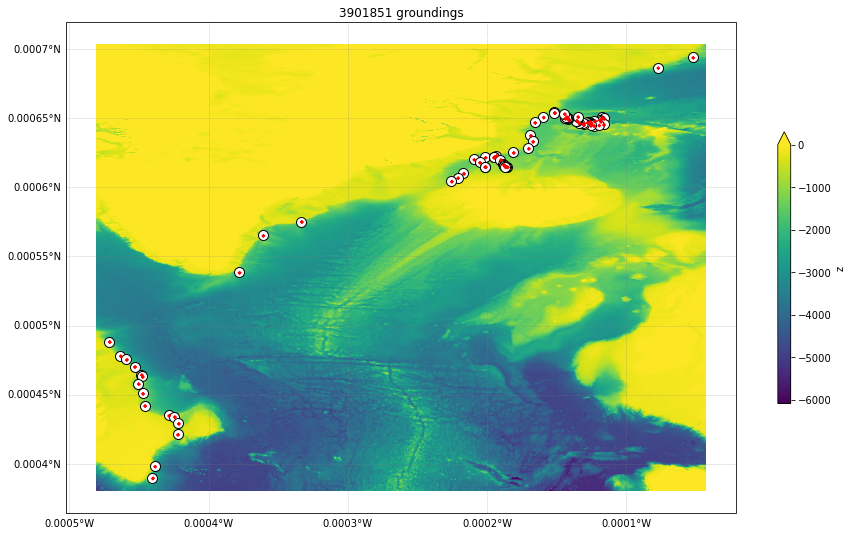

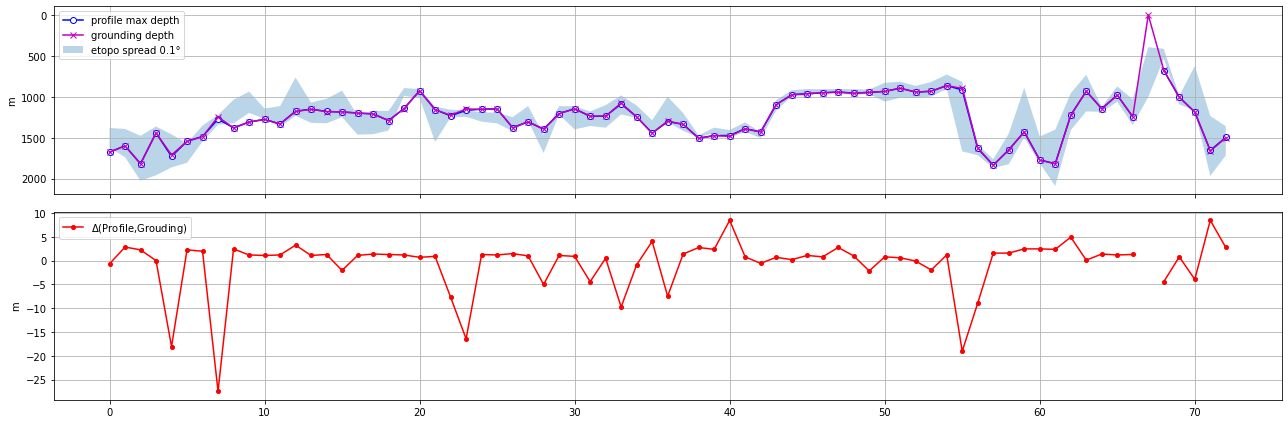

In [58]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)
etopo.where((etopo['x']>ds['LONGITUDE'].min()-1)&(etopo['x']<ds['LONGITUDE'].max()+1)&(etopo['y']>ds['LATITUDE'].min()-1)&(etopo['y']<ds['LATITUDE'].max()+1),
            drop=True)['z'].plot(vmax=0,cbar_kwargs={'shrink': 0.5})
plt.plot(ds['LONGITUDE'],ds['LATITUDE'],'ow',markersize=10,markeredgecolor='k')
#plt.plot(ds['LONGITUDE'].isel(CYCLE_NUMBER=60),ds['LATITUDE'].isel(CYCLE_NUMBER=60),'sg',markersize=10)

plt.plot(etopo_on_float['x'],etopo_on_float['y'],'.r',markersize=1,alpha=0.3)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title(str(wmo)+' groundings')

fig, ax = plt.subplots(2,1,figsize=(18,6),sharex=True)

l=len(dg['CYCLE_NUMBER'])

ax[0].invert_yaxis()
ax[0].plot(range(l),ds['Z'],"o-b",markerfacecolor='w',label='profile max depth')
ax[0].plot(range(l),dg['Z'],"x-m",label='grounding depth')
ax[0].fill_between(range(l),etopo_on_float['z'].min('PTS'),etopo_on_float['z'].max('PTS'),alpha=0.3,label='etopo spread 0.1°')
#ax[0].fill_between(range(l),gebco_on_float['elevation'].min('PTS'),gebco_on_float['elevation'].max('PTS'),alpha=0.3,label='gebco spread')
ax[0].set_ylabel('m')
ax[0].legend()

ax[1].plot(range(l),dg['Z'].values-ds['Z'].values,"o-r",markersize=4,label=r'$\Delta$(Profile,Grouding)')

ax[1].set_ylabel('m')
ax[1].legend()
plt.tight_layout()

**spread** is the interpolated bathymetry within an extended area around the GPS fix following the grounding. The extension is very and volontaraly approximative, it's just to take into account the horizontal displacement of the float during its ascent. 

## 3rd case, grounding occurs during descent to drifting depth

In [15]:
# DATA LOADING
wmo=6902855
dac='coriolis'

dt = xr.open_dataset("/home/ref-argo/gdac/dac/"+dac+"/"+str(wmo)+"/"+str(wmo)+"_Rtraj.nc")
dd = xr.open_dataset("/home/ref-argo/gdac/dac/"+dac+"/"+str(wmo)+"/"+str(wmo)+"_prof.nc")

# JUST CHECKING GROUNDINGS, NO MATTER WHEN DURING THE CYCLE
np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]

array([ 80,  81,  84,  85,  86, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213])

In [16]:
# GROUNDING DATA, BUT WE'LL KEEP ONLY GROUNDINGS OCCURED DURING DESCENT TO PARKIN
# groupby is here in case there's more than 1 grounding in the cycle, in that case we take the first, closer to the previous profile
dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').first()

# GROUNDING DATE < PARKING DRIFT START ?
# Here we make sure that grounding occurs in the descent to parking depth. We do that comparing grounding time 
# (meas code 901) and parking drift start (meas code 250)
park_start = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==250.,drop=True)
a = [(dg['JULD'][i].values - park_start['JULD'].where(park_start['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)<=0 
     for i in range(len(dg['CYCLE_NUMBER'].values))]
a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
dg = dg.where(dg['grd_on_prf']==True,drop=True)

dg

<xarray.Dataset>
Dimensions:       (CYCLE_NUMBER: 15)
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 84.0 85.0 196.0 ... 206.0 207.0 208.0
Data variables:
    JULD          (CYCLE_NUMBER) datetime64[ns] 2019-09-29T00:16:59.999999744...
    PRES          (CYCLE_NUMBER) float32 1.259e+03 836.0 ... 11.0 1.359e+03
    grd_on_prf    (CYCLE_NUMBER) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2020-08-28T22:36:46Z creation; 2021-10-22T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.1
    Conventions:                  Argo-3.1 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_044q
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [17]:
#Time between grounding and parking start, should be 0
print(0, 'Grounding time',' / ','Parking start')
for i in dg['CYCLE_NUMBER'].values:    
    t1=dg['JULD'].sel(CYCLE_NUMBER=i).values
    t2=park_start['JULD'].where(park_start['CYCLE_NUMBER']==i,drop=True).values[0]    
    print(i, t2,' / ',t1,' / ',np.timedelta64(t1-t2,'m'),'(',np.timedelta64(t1-t2,'h'),')')

0 Grounding time  /  Parking start
84.0 2019-09-29T00:16:59.999999744  /  2019-09-29T00:16:59.999999744  /  0 minutes ( 0 hours )
85.0 2019-10-03T21:05:00.000000000  /  2019-10-03T21:05:00.000000000  /  0 minutes ( 0 hours )
196.0 2021-04-11T00:52:00.000000000  /  2021-04-11T00:52:00.000000000  /  0 minutes ( 0 hours )
197.0 2021-04-16T01:14:00.000000000  /  2021-04-16T01:14:00.000000000  /  0 minutes ( 0 hours )
198.0 2021-04-21T01:44:00.000000000  /  2021-04-21T01:44:00.000000000  /  0 minutes ( 0 hours )
199.0 2021-04-26T00:21:00.000000000  /  2021-04-26T00:21:00.000000000  /  0 minutes ( 0 hours )
200.0 2021-04-30T23:14:00.000000000  /  2021-04-30T23:14:00.000000000  /  0 minutes ( 0 hours )
201.0 2021-05-06T00:58:00.000000000  /  2021-05-06T00:58:00.000000000  /  0 minutes ( 0 hours )
202.0 2021-05-11T00:30:00.000000000  /  2021-05-11T00:30:00.000000000  /  0 minutes ( 0 hours )
203.0 2021-05-16T00:05:00.000000000  /  2021-05-16T00:05:00.000000000  /  0 minutes ( 0 hours )
204.0 2

In [18]:
# PREVIOUS PROFILE DATA AND LAST GPS FIX
ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,dg['CYCLE_NUMBER'].values-1)])[['PRES','JULD',
                                                                                                        'CYCLE_NUMBER',
                                                                                                        'LATITUDE',
                                                                                                        'LONGITUDE']].groupby('CYCLE_NUMBER').last()
# MAX PRES AND DEPTH CALCULATION for ds and dg
ds = ds.max('N_LEVELS')
ds['Z'] = -1*xr.DataArray(gsw.z_from_p(ds['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')

# PREVIOUS CYCLE LAST GPS FIX (meas code 703)
dp = dt[['CYCLE_NUMBER','JULD','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==703.,drop=True).groupby('CYCLE_NUMBER').last()
dp = dp.where(dp['CYCLE_NUMBER']==ds['CYCLE_NUMBER'],drop=True)
ds['LAST_LONGITUDE'] = xr.DataArray(dp['LONGITUDE'].values,dims='CYCLE_NUMBER')
ds['LAST_LATITUDE'] = xr.DataArray(dp['LATITUDE'].values,dims='CYCLE_NUMBER')
ds['LAST_JULD'] = xr.DataArray(dp['JULD'].values,dims='CYCLE_NUMBER')
ds

<xarray.Dataset>
Dimensions:         (CYCLE_NUMBER: 15)
Coordinates:
  * CYCLE_NUMBER    (CYCLE_NUMBER) float64 83.0 84.0 195.0 ... 205.0 206.0 207.0
Data variables:
    PRES            (CYCLE_NUMBER) float32 1.981e+03 1.257e+03 ... 14.9
    JULD            (CYCLE_NUMBER) datetime64[ns] 2019-09-28T11:46:20 ... 202...
    LATITUDE        (CYCLE_NUMBER) float64 23.62 23.58 26.32 ... 26.69 25.45
    LONGITUDE       (CYCLE_NUMBER) float64 -89.84 -89.82 ... -95.83 -95.64
    Z               (CYCLE_NUMBER) float64 1.959e+03 1.245e+03 ... 1.36e+03 14.8
    LAST_LONGITUDE  (CYCLE_NUMBER) float64 -89.88 -89.84 ... -95.84 -95.62
    LAST_LATITUDE   (CYCLE_NUMBER) float64 23.63 23.55 26.3 ... 26.66 25.43
    LAST_JULD       (CYCLE_NUMBER) datetime64[ns] 2019-09-28T12:32:19.9999984...

In [19]:
#Time between grounding and previous profile date
print(0, 'Profile N-1 date',' / ','Profile N-1 last fix',' / ','Grounding')
for i in dg['CYCLE_NUMBER'].values:    
    t1=dg['JULD'].sel(CYCLE_NUMBER=i).values
    t2=ds['LAST_JULD'].sel(CYCLE_NUMBER=i-1).values
    t3=ds['JULD'].sel(CYCLE_NUMBER=i-1).values
    print(i, t3,' / ',t2,' / ',t1,' / ',np.timedelta64(t1-t2,'m'),'(',np.timedelta64(t1-t2,'h'),')')

0 Profile N-1 date  /  Profile N-1 last fix  /  Grounding
84.0 2019-09-28T11:46:20.000000000  /  2019-09-28T12:32:19.999998464  /  2019-09-29T00:16:59.999999744  /  704 minutes ( 11 hours )
85.0 2019-10-03T12:21:20.000000000  /  2019-10-03T13:04:32.000000000  /  2019-10-03T21:05:00.000000000  /  480 minutes ( 8 hours )
196.0 2021-04-10T12:01:20.000000256  /  2021-04-10T12:46:06.999998720  /  2021-04-11T00:52:00.000000000  /  725 minutes ( 12 hours )
197.0 2021-04-15T12:03:20.000000000  /  2021-04-15T12:47:30.000001024  /  2021-04-16T01:14:00.000000000  /  746 minutes ( 12 hours )
198.0 2021-04-20T12:15:20.000000000  /  2021-04-20T12:58:17.999996672  /  2021-04-21T01:44:00.000000000  /  765 minutes ( 12 hours )
199.0 2021-04-25T12:21:20.000000000  /  2021-04-25T13:04:46.999998976  /  2021-04-26T00:21:00.000000000  /  676 minutes ( 11 hours )
200.0 2021-04-30T11:22:20.000000000  /  2021-04-30T12:05:09.000003584  /  2021-04-30T23:14:00.000000000  /  668 minutes ( 11 hours )
201.0 2021-05-

In [20]:
#SPREAD ETOPO : Array of random points around (spread 0.2°) position to interpolate bathy
LO = np.array([np.random.uniform(i-0.1,i+0.1,100) for i in ds['LAST_LONGITUDE'].values])
LA = np.array([np.random.uniform(i-0.1,i+0.1,100) for i in ds['LAST_LATITUDE'].values])
x=xr.DataArray(LO,dims=['CYCLE_NUMBER','PTS'])
y=xr.DataArray(LA,dims=['CYCLE_NUMBER','PTS'])
etopo_on_float = -1*etopo.interp(x=x,y=y,method='linear')
#gebco_on_float = -1*gebco.interp(lon=x,lat=y,method='linear')

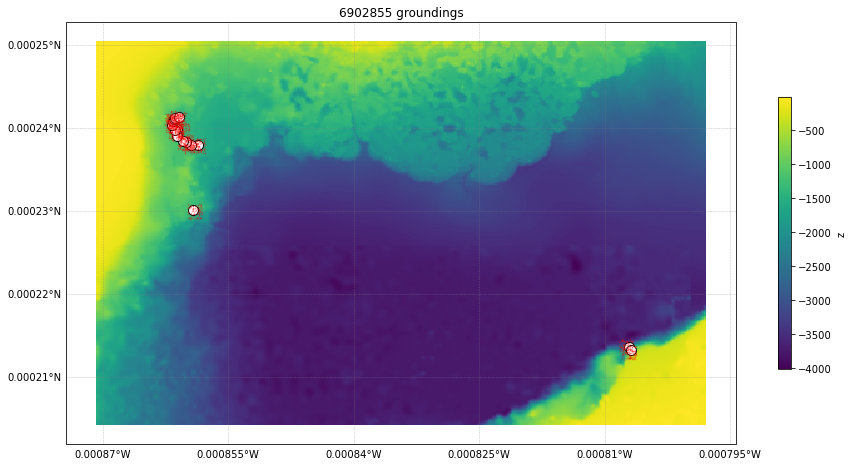

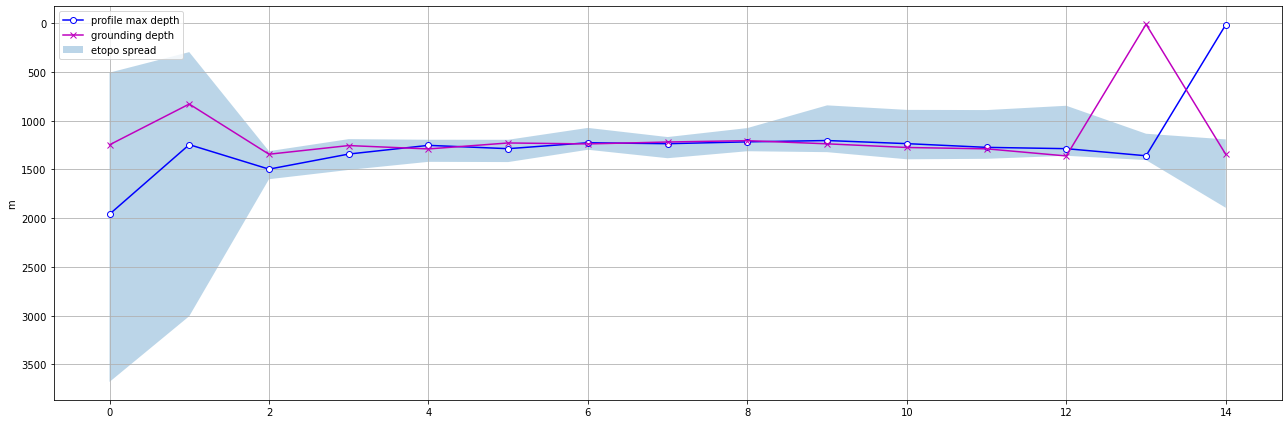

In [21]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)
etopo.where((etopo['x']>ds['LONGITUDE'].min()-1)&(etopo['x']<ds['LONGITUDE'].max()+1)&(etopo['y']>ds['LATITUDE'].min()-1)&(etopo['y']<ds['LATITUDE'].max()+1),
            drop=True)['z'].plot(cbar_kwargs={'shrink': 0.5})
plt.plot(ds['LONGITUDE'],ds['LATITUDE'],'ow',markersize=10,markeredgecolor='k')
plt.plot(etopo_on_float['x'],etopo_on_float['y'],'.r',markersize=1,alpha=0.3)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title(str(wmo)+' groundings')

fig, ax = plt.subplots(1,1,figsize=(18,6),sharex=True)

l=len(dg['CYCLE_NUMBER'])

ax.invert_yaxis()
ax.plot(range(l),ds['Z'],"o-b",markerfacecolor='w',label='profile max depth')
ax.plot(range(l),dg['Z'],"x-m",label='grounding depth')
ax.fill_between(range(l),etopo_on_float['z'].min('PTS'),etopo_on_float['z'].max('PTS'),alpha=0.3,label='etopo spread')
#ax.fill_between(range(l),gebco_on_float['elevation'].min('PTS'),gebco_on_float['elevation'].max('PTS'),alpha=0.3,label='gebco spread')
ax.set_ylabel('m')
ax.legend()

plt.tight_layout()